# PCA, Inertia, and Silhouette plots
Data Analysis Python Pandas Data Manipulation Data Visualization PCA Plot Inertia Plot Silhouette Plot External Dataset

Suppose you have the following 
[dataset](https://docs.google.com/spreadsheets/d/1DrvkAWnO1psWkFN1YVt891sHe4yHl4ljNPUVlCsI95M/edit#gid=2039795889)
which contains (1st tab) a list of items purchased by a given user, (2nd tab) a mapping which maps the item_id to the item name and price, (3rd tab) a matrix that formats data from sheet 1 into a matrix with users in rows and the number of each item_id purchased in columns.

With this data, we want to see if we can cluster types of groceries that are typically purchased together. Before we cluster, however, we need to see if we can simplify the data a bit so it's easier to work with / can be generalized with less variables.

Knowing this, can you create the following charts for each analysis:

- PCA analysis: Line chart that with variance on the y-axis and number of variables on the x-axis. This will help us figure out if we can collapse the dataset into less variables.
- Inertia analysis: Line chart with sum of squared error on y-axis and number of clusters on the x-axis. This metric allows us to understand how dense the clusters would be depending on the number of clusters selected.
- Silhouette analysis: Line chart with silhouette coefficient on the y-axis and the number of clusters on the x-axis. The silhouette coefficient measures the intra-cluster distance. This will help us understand how closely the clusters are to each other.

Using this information, can you provide a recommendation for the number of clusters we should use?

Note: The purpose of doing this exercise is to explore ways of analyzing data that could be generalized by a group (think clustering). This dataset will be used in a couple of future questions that continue to explore clustering data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

filename = 'q143_output.csv'
df = pd.read_csv(filename)
df.set_index('user_id', inplace=True)
print(df.shape)
df.head()

(24885, 48)


,item01,item02,item03,item04,item05,item06,item07,item08,item09,item10,...,item39,item40,item41,item42,item43,item44,item45,item46,item47,item48
user_id,,,,,,,,,,,,,,,,,,,,,
47,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
68,0,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
113,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
123,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
223,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


C:\Users\tho\Anaconda3\lib\site-packages\ipykernel_launcher.py:26: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


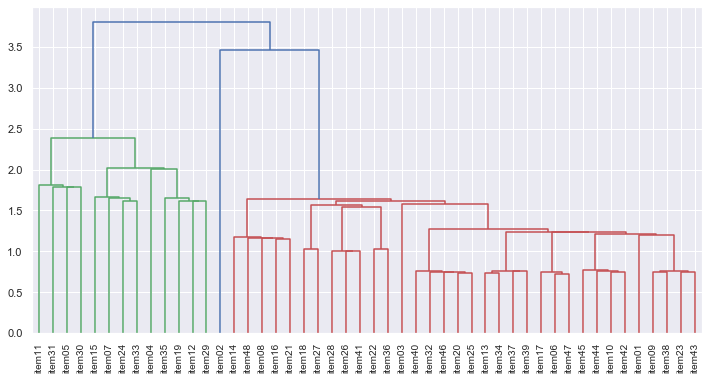

In [2]:
import scipy.cluster.hierarchy as hc
import scipy.spatial.distance as dist
import sklearn.metrics.pairwise as pw

# simple intro/example at https://www.analyticsvidhya.com/blog/2019/05/beginners-guide-hierarchical-clustering/


def build_sim_matrix(df):
    labels = list(df.index)
    sim = pw.cosine_similarity(df)
    np.fill_diagonal(sim, np.nan)
    return sim, labels
    
    
def build_linkage(sim, method='single'):
    """
    method can single, centroid, median, complete, etc
    see docs for scipy.cluster.hierarchy.linkage
    
    recipe from https://gist.github.com/tommct/c3ffca76251aba2351da7e3b1183bf5a
    """
    distances = 1 - sim # so that 0 is close and 1 is far.
    np.fill_diagonal(distances, 0)
    distances = np.clip(distances, 0, 1)
    dists = dist.squareform(dist.pdist(distances, 'sqeuclidean'))
    links = hc.linkage(dists, method=method)
    return links


def plot_dendrogram(linkage, labels):
    """
    plot dendrogram given the linkage matrix 
    returned by scipy.cluster.hierarchy.linkage
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    dd = hc.dendrogram(linkage, labels=labels, ax=ax)
    ax.tick_params(axis='x', which='major', labelsize=10)

    
similarity_matrix, labels = build_sim_matrix(df.T)
links = build_linkage(similarity_matrix)
plot_dendrogram(links, labels)


In [3]:
def get_cluster_labels(links, n_clusters):
    """ 
    links: linkage matrix, size n by 4
    n_clusters: integer >= 2
    returns integer array of size n, indicating cluster for this point
    """
    low, high = links[-n_clusters,2], links[-n_clusters+1,2]
    threshold = (low + high)/2
    return hc.fcluster(links, threshold, criterion='distance')

clusters = get_cluster_labels(links, 2)
clusters

array([2, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 1, 1, 1, 2, 1, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2], dtype=int32)

# Silhouette: 2 or 3 clusters (but they're not great at all)

Silhouette analysis: 
Line chart with silhouette coefficient on the y-axis 
and the number of clusters on the x-axis. 
The silhouette coefficient measures the intra-cluster distance. 
This will help us understand how closely the clusters are to each other.

[-0.06604288749013812,
 0.004700358685469552,
 0.005407201113605824,
 -0.06604288749013812,
 -0.06248665436764588,
 -0.06137475698932565,
 -0.06777742769949958,
 -0.06944327304971913,
 -0.07191538316711053,
 -0.07162521483445279]

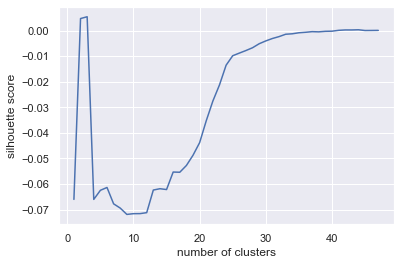

In [4]:
from sklearn import metrics
from sklearn.metrics import pairwise_distances

def generate_hierarchical_clusters_plot_silhouette_score(df, links):
    """
    The best value is 1 and the worst value is -1. 
    Values near 0 indicate overlapping clusters. 
    Negative values generally indicate that a sample has been assigned to the wrong cluster, 
    as a different cluster is more similar.
    """
    possible_n_clusters = list(range(1,df.shape[0]))
    scores = [
        metrics.silhouette_score(
            df, 
            get_cluster_labels(links, n_clusters), 
            metric='euclidean'
        )
        for n_clusters in possible_n_clusters
    ]

    fig = plt.plot(
        possible_n_clusters,
        scores
    )
#     plt.yscale('log')
    plt.xlabel('number of clusters')
    plt.ylabel('silhouette score')
    
    return scores

    
silhouette_scores = generate_hierarchical_clusters_plot_silhouette_score(df.T, links)
silhouette_scores[:10]

# Inertia analysis
Inertia analysis: Line chart with sum of squared error on y-axis and number of clusters on the x-axis. This metric allows us to understand how dense the clusters would be depending on the number of clusters selected.


# PCA: 4 or 5 components

In [5]:
from sklearn.decomposition import PCA

def build_pca(df):
    pca = PCA() # as many components as there are features
    pca.fit(df)
    return pca

pca = build_pca(df)
print(pca.explained_variance_ratio_[:10])

[0.1486854  0.04044879 0.03715107 0.03636788 0.03236198 0.02745954
 0.02657785 0.02460473 0.02314124 0.02098734]


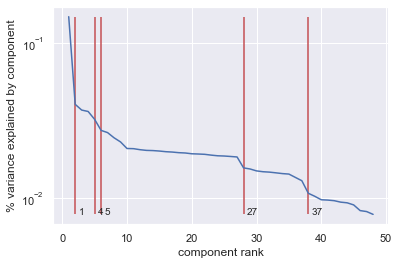

In [6]:
def scree_plot(pca, threshold=.1):
    """
    Plot a scree plot of given PCA.
    Add vertical lines when variance drops relatively by more than threshold (10% by default)
    Add text indicating number of components BEFORE the big drop happens,
    which is the number of clusters we'd want.
    https://stats.stackexchange.com/a/17206
    """
    evr = pca.explained_variance_ratio_
    fig = plt.plot(np.arange(1,len(evr)+1), evr)
    plt.yscale('log')
    plt.xlabel('component rank')
    plt.ylabel('% variance explained by component')
    
    # plot vlines when explained variance drops > passed threshold
    drop_indices = []
    for i in range(len(evr)-1):
        drop = (evr[i] - evr[i+1]) / evr[i]
        if drop >= threshold:
            drop_indices.append(i+2)
    plt.vlines(drop_indices,evr[-1],evr[0],color='r')
    [plt.text(i+0.5, evr[-1], i-1) for i in drop_indices]
    
    
scree_plot(pca)